In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, mpld3
import os
import fnmatch
import csv
import pickle
import warnings
import torch
import time
import scipy


warnings.filterwarnings('ignore')

### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from termcolor import colored
import tensorflow.keras.backend as K

### Create architecture

In [3]:
def make_model(inputs, n_outputs):
    hidden_layer_1 = tf.layers.dense(inputs, 10, activation=tf.nn.sigmoid)
    hidden_layer_2 = tf.layers.dense(hidden_layer_1, 15, activation=tf.nn.sigmoid)
    hidden_layer_3 = tf.layers.dense(hidden_layer_2, 5, activation=tf.nn.sigmoid)
    #hidden_layer_3 = tf.layers.dropout(hidden_layer_3, 0.15)
    output = tf.layers.dense(hidden_layer_3, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)
    return output



### Prepare data for training

Cost function: $\chi^2 = 1/N \sum (y - y_{pred})^2 / \sigma^2$ \
Optimizer: AdamOptimizer, $\eta = 0.02$\

Training points are generated by Monte Carlo sampling; for the set of training points $[dE, D_i, \sigma_i]$, a set of MC training points is generated by adding a stochastic noise signal on top of the the data with a std equal to the corresponding error on that point. 

- **train_x**: $[dE, t_{exp}]$
- **train_y**: $D_i$ + rand.norm(0, $\sigma_i$)

Repetitive training of the NN (number of repetitions = $N_{rep}$) on each set of MC pseudo data yields a prediction that is distributed with a mean and std corresponding to the mean and error of the original training set. 


In [4]:
tf.reset_default_graph()
from copy import copy
from sklearn.model_selection import train_test_split
%run Functions.ipynb


input_dim = 3
nbins = 150

x = tf.placeholder("float", [None, 3], name="x")
y = tf.placeholder("float", [None, 1], name="y")
sigma = tf.placeholder("float", [None, 1], name="sigma")

df_full1 = pd.read_csv('Data/May/training_merged_4.csv', header=0)  ## Insert here the raw data
df_full1 = df_full1.drop_duplicates(subset=['y'])
df_full1 = df_full1.sort_values(by='x')
#df_train_pseudo = pd.read_csv('Data/May/pseudo_trainingsdata_x.csv', header=0, names=['x', 'time', 'energy', 'y', 'sigma'])
df_full = df_full1 #pd.concat([df_full1, df_train_pseudo], axis=0, ignore_index=True)


df_full = df_full[(df_full['x'] < -.1)& (df_full['x'] > -.8)]

df_full.describe()

,x,y,sigma,time,energy
count,413.000000,413.000000,413.000000,413.000000,413.000000
mean,-0.452720,0.188918,0.009589,0.389831,1.525424
std,0.202342,0.181991,0.018280,0.421040,0.663513
min,-0.799825,0.102072,0.000395,0.100000,0.600000
25%,-0.628420,0.102754,0.000689,0.100000,0.600000
50%,-0.449809,0.112185,0.001495,0.100000,2.000000
75%,-0.278855,0.150728,0.006942,1.000000,2.000000
max,-0.103330,0.874543,0.111361,1.000000,2.000000


Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


,x,y,sigma,time,energy
2237,-0.209054,0.116844,0.003106,1.0,2.0
16552,-0.549343,0.187295,0.010359,0.1,0.6
1810,-0.632605,0.125556,0.003202,1.0,2.0
8020,-0.203020,0.102853,0.000762,0.1,2.0
547,-0.238198,0.143669,0.003249,1.0,0.6
...,...,...,...,...,...
6940,-0.363313,0.103807,0.000927,0.1,2.0
16370,-0.749215,0.115189,0.003549,0.1,0.6
7167,-0.329807,0.103225,0.000723,0.1,2.0
4058,-0.793125,0.102568,0.000699,0.1,2.0


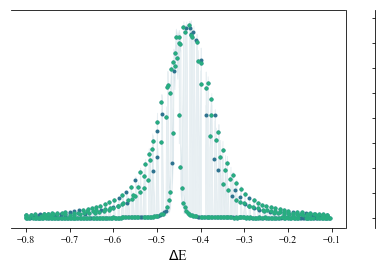

In [5]:
### Make database with nbins

train_mean, train_var = vectorize_mean(df_full['x'], df_full['y'], nbins), vectorize_variance(df_full['x'], df_full['y'], nbins)


df_train, df_test = train_test_split(df_full, test_size=0.2, random_state=28)

cols=[ 'x', 'time', 'energy', 'sigma']
train_inputs = df_train.drop(['y'], axis=1)[cols]
train_outputs = df_train['y']
test_inputs = df_test.drop(['y'], axis=1)[cols]
test_outputs = df_test['y']

train_x = train_inputs.drop('sigma', axis=1).to_numpy()
train_y = train_outputs.to_numpy()
train_sigma = train_inputs['sigma'].to_numpy()
test_x = test_inputs.drop('sigma', axis=1).to_numpy()
test_y = test_outputs.to_numpy()
test_sigma = test_inputs['sigma'].to_numpy()

predictions = make_model(x,1)

from matplotlib import rc
from matplotlib import cm
cm_subsection = np.linspace(0,1,9) 
colors = [cm.viridis(x) for x in cm_subsection ]

rc('text',usetex=False)
rc('font',**{'family':'sans-serif','sans-serif':['Times New Roman']})

hfont = {'fontname':'Times New Roman'}
csfont = {'fontname':'Comic Sans MS'}


fig, ax = plt.subplots(1,1)
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True


#ax.plot(df_full['x'] , df_full['y'] + df_full['sigma'], '.',  color=colors[7], alpha = .1)
ax.fill_between(df_full['x'] , df_full['y'] - df_full['sigma'], df_full['y'] + df_full['sigma'], color=colors[3], alpha = .1)
ax.plot(df_full['x'] , df_full['y'], '.',  color=colors[3])
ax.plot(df_train['x'] , df_train['y'], '.',  color=colors[5])
ax.set_xlabel('$\Delta$E', fontsize=14)
ax.get_yaxis().set_ticklabels([])

ax.spines['left'].set_position(('data', 0))

df_full.head()


df_train

In [6]:
relative_error = np.divide(train_sigma, train_y)
treshold = 0.0001
treshold_error_index = np.where(relative_error >= treshold)[0]
train_x, train_y, train_sigma = train_x[treshold_error_index], train_y[treshold_error_index], train_sigma[treshold_error_index]
N_train = len(train_x)

relative_error = np.divide(test_sigma, test_y)
treshold_error_index = np.where(relative_error > treshold)[0]
test_x, test_y, test_sigma = test_x[treshold_error_index], test_y[treshold_error_index], test_sigma[treshold_error_index]
N_test = len(test_x)




## Create MC replicas

In [7]:
### Create array of Nrep training samples
Nrep = 1000
N_train = len(train_x)
N_test = len(test_x)
#pbar = tqdm(total=Nrep)
def pseudodata(Nrep):
    train_y_reps = np.zeros(shape=(N_train, Nrep))
    test_y_reps = np.zeros(shape=(N_test, Nrep))
    i=0
    while i < Nrep:
        train_rep = np.random.normal(0, train_sigma)
        test_rep = np.random.normal(0, test_sigma)
        train_y_reps[:,i] = (train_y + train_rep).reshape(N_train)
        test_y_reps[:,i] = (test_y + test_rep).reshape(N_test)

        i+=1 
    std_reps = np.std(train_y_reps, axis=1)
    mean_reps = np.mean(train_y_reps, axis=1)
    
    return mean_reps, std_reps
mean_reps100, std_reps100 = pseudodata(100)
mean_reps500, std_reps500 = pseudodata(500)
mean_reps1000, std_reps1000 = pseudodata(1000)
mean_reps5000, std_reps5000 = pseudodata(5000)

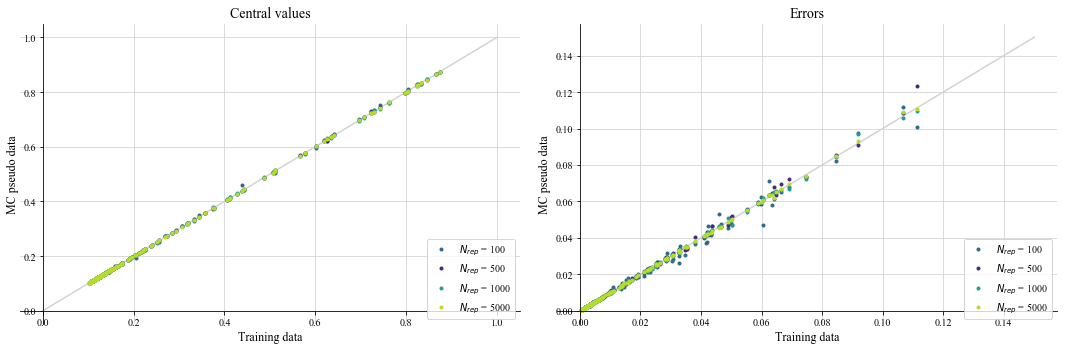

In [8]:
from matplotlib import cm
cm_subsection = np.linspace(0,1,10) 
colors = [ cm.viridis(x) for x in cm_subsection ]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.set_title('Central values', fontsize=14)
ax1.plot(np.linspace(0,1,10), np.linspace(0,1,10), color='lightgrey')
ax1.plot(train_y, mean_reps100, '.', color = colors[3], label = '$N_{rep}$ = 100')
ax1.plot(train_y, mean_reps500, '.', color = colors[1], label = '$N_{rep}$ = 500')
ax1.plot(train_y, mean_reps1000, '.', color = colors[5], label = '$N_{rep}$ = 1000')
ax1.plot(train_y, mean_reps5000, '.', color = colors[8], label = '$N_{rep}$ = 5000')
ax1.grid(True, color='lightgray')
ax1.set_xlabel(r'Training data', fontsize=12)
ax1.legend(loc='lower right')
ax1.spines['left'].set_position(('data', 0))
ax1.spines['bottom'].set_position(('data', 0))
ax1.set_ylabel(r'MC pseudo data', fontsize=12)

ax2.grid(True, color='lightgray')
ax2.set_title('Errors', fontsize=14)
ax2.plot(np.linspace(0,0.15,10), np.linspace(0,0.15,10), color='lightgrey')
ax2.plot(train_sigma, std_reps100, '.', color=colors[3], label = '$N_{rep}$ = 100')
ax2.plot(train_sigma, std_reps500, '.', color=colors[1], label = '$N_{rep}$ = 500')
ax2.plot(train_sigma, std_reps1000, '.', color=colors[5], label = '$N_{rep}$ = 1000')
ax2.plot(train_sigma, std_reps5000, '.', color=colors[8], label = '$N_{rep}$ = 5000')
ax2.set_xlabel(r'Training data', fontsize=12)
ax2.legend(loc='lower right')

ax2.set_ylabel(r'MC pseudo data', fontsize=12)
ax2.spines['left'].set_position(('data', 0))
ax2.spines['bottom'].set_position(('data', 0))
plt.tight_layout()
plt.show()

In [9]:
## Beam energy interpolation

import random

part1 = 1000
N_pred = 10 * part1

interpol_energy1 = .2 #*100 keV
interpol_energy2 = .4 #*100 keV
interpol_energy3 = .6
interpol_energy4 = .8
interpol_energy5 = 1.2
interpol_energy6 = 1.8
interpol_energy7 = 2
interpol_energy8 = 2.2
interpol_energy9 = 2.5
interpol_energy10 = 3



interpol_time = .1
E_min = -.8
E_max = -.1

#Energy --> Energy range veranderen zodat het alleen interpolatie doet op E. 
predict_x = np.zeros(shape=(N_pred, 3))
predict_x[0*part1:1*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[1*part1:2*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[2*part1:3*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[3*part1:4*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[4*part1:5*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[5*part1:6*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[6*part1:7*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[7*part1:8*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[8*part1:9*part1, 0] = np.linspace(E_min,E_max,part1)
predict_x[9*part1:10*part1, 0] = np.linspace(E_min,E_max,part1)

#Time
predict_x[:,1] = interpol_time * np.ones(N_pred)

# E_beam
predict_x[0*part1:1*part1,2] = interpol_energy1 * np.ones(part1)
predict_x[1*part1:2*part1,2] = interpol_energy2 * np.ones(part1)
predict_x[2*part1:3*part1,2] = interpol_energy3 * np.ones(part1)
predict_x[3*part1:4*part1,2] = interpol_energy4 * np.ones(part1)
predict_x[4*part1:5*part1,2] = interpol_energy5 * np.ones(part1)
predict_x[5*part1:6*part1,2] = interpol_energy6 * np.ones(part1)
predict_x[6*part1:7*part1,2] = interpol_energy7 * np.ones(part1)
predict_x[7*part1:8*part1,2] = interpol_energy8 * np.ones(part1)
predict_x[8*part1:9*part1,2] = interpol_energy9 * np.ones(part1)
predict_x[9*part1:10*part1,2] = interpol_energy10 * np.ones(part1)

predict_x2 = copy(predict_x)
predict_x2[:,1] = 1 * np.ones(N_pred)
predict_x = np.vstack([predict_x, predict_x2])

In [10]:
Nrep = 1000

train_y_reps = np.zeros(shape=(N_train, Nrep))
test_y_reps = np.zeros(shape=(N_test, Nrep))
i=0
while i < Nrep:
        train_rep = np.random.normal(0, train_sigma)
        test_rep = np.random.normal(0, test_sigma)
        train_y_reps[:,i] = (train_y + train_rep).reshape(N_train)
        test_y_reps[:,i] = (test_y + test_rep).reshape(N_test)
        i+=1 
        
std_reps = np.std(train_y_reps, axis=1)
mean_reps = np.mean(train_y_reps, axis=1)

train_sigma.shape

train_x[100]

array([-0.30907887,  0.1       ,  0.6       ])

In [14]:
import time
from datetime import datetime
from shutil import copyfile

training_epochs = 50000
max_rising_epochs = 10000 #The amount of epochs the minimzer is allowed to overfit before it stops
display_step = 1000
chi_array = []

tic = time.time()

### Define cost and optimizer
cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="cost_function")
custom_cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="custom_cost_function")
eta = 3e-2
optimizer = tf.train.AdamOptimizer(learning_rate=eta, beta1=0.9, beta2=0.999, epsilon=1e-08).minimize(cost)
saver = tf.train.Saver(max_to_keep=1000)

train_sigma = train_sigma.reshape(N_train,1)
test_sigma = test_sigma.reshape(N_test,1)
print(sigma.shape)
i = 0
Nrep = 30

while i < (Nrep):
    
    """Training data: train_y = D_i + rand.norm(0, sigma_i);
    use train_y = gaus_y + rand.norm(0, sigma_i) in case of Closure testing"""
    
    train_y = train_y_reps[:,i].reshape(N_train,1)
    test_y = test_y_reps[:,i].reshape(N_test,1)

    ### Train and validate
    prev_test_cost = 100
    prev_epoch=0
    avg_cost = 0.0
    
    now = datetime.now()
  
    dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
    d_string = now.strftime("%d.%m.%Y")
    t_string = now.strftime("%H:%M:%S")

    array_train = []
    array_test = []
    
    print("Start training on", '%04d' %(N_train), "and validating on", '%0.4d' %(N_test), "samples")
    # Create a saver.

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch in range(training_epochs):

            _, c = sess.run([optimizer, cost], 
                            feed_dict={
                                x: train_x,
                                y: train_y,
                                sigma: train_sigma
                            })
            
            
            avg_cost = c 

            test_cost = cost.eval({x: test_x, y: test_y, sigma: test_sigma})
            

            if epoch % display_step == 0:
                print("Epoch:", '%04d' % (epoch+1), "| Training cost=", "{:.9f}".format(avg_cost), "| Validation cost=", "{:.9f}".format(test_cost))
                array_train.append(avg_cost)
                array_test.append(test_cost)
                saver.save(sess, 'Models/my-model.ckpt', global_step=epoch , write_meta_graph=False) 
                

            if test_cost >= prev_test_cost and epoch-prev_epoch >= max_rising_epochs:
                print(colored("\n The session stopped because of overfitting...","red"))
                print("Start overfitting at epoch:", '%04d' % (epoch), "| Validation cost =", "{:.9f}".format(test_cost), "| Train cost=", "{:.9f}".format(avg_cost))
                array_train.append(avg_cost)
                array_test.append(test_cost)
                saver.save(sess, 'Models/my-model.ckpt', global_step=epoch , write_meta_graph=False) 
                break
        
            elif test_cost < prev_test_cost:
                prev_test_cost = test_cost
                prev_epoch = epoch
                
        best_iteration = np.argmin(array_test) 
        best_epoch = best_iteration * display_step
        best_model = 'Models/my-model.ckpt-%(s)s' % {'s': best_epoch}
        
        
        print("Optimization Finished! Best model after epoch %(s)s" % {'s': best_epoch})
        
        
        saver.restore(sess, best_model)
        
        
        saver.save(sess, 'Models/Best_model/%(s)s_round2_%(i)s' % {'s': d_string, 'i': i})
    
        
        predictions_values = sess.run(predictions, 
                            feed_dict={
                                x: train_x,
                                y: train_y 
                            }) 
        
        
        extrapolation = sess.run(predictions,
                            feed_dict={
                                x: predict_x
                            })
    
    sess.close()

    # save to csv file
    predictions_values = predictions_values.reshape(N_train,)
    toc = time.time()
    print("Elapsed time:", toc-tic)
    
    now = datetime.now()
  
    dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
    d_string = now.strftime("%d.%m.%Y")
    t_string = now.strftime("%H:%M:%S")
    
    
    #foot = np.array(seednumber)
    a = np.array(train_x[:,0])
    b = np.array(train_y)
    c = np.array(predictions_values)
    d = array_train
    e = array_test
    g = np.array(train_x[:,1])
    h = np.array(train_x[:,2])
    k1 = np.array(predict_x[:,0])
    k2 = np.array(predict_x[:,1])
    k3 = np.array(predict_x[:,2])
    l = np.array(extrapolation)
    
    chi_array.append(d[-1])
    

    best_chi = np.where(array_test == min(array_test))
    np.savetxt('Data/Results/%(date)s.part1/xyp1p2_all_e%(epoch)s_round2_%(i)s.csv' % {"date": d_string, "epoch": training_epochs, "i": i }, list(zip(a,b,c,g,h)),  delimiter=',',  header="best iteration: %(p)s" % {"p": best_chi}, fmt='%f')
    np.savetxt('Data/Results/%(date)s.part1/chi_all_e%(epoch)s_round2_%(i)s.csv' % {"date": d_string, "epoch": training_epochs, "i": i }, list(zip(d,e)),  delimiter=',',  header="best iteration: %(p)s" % {"p": best_chi}, fmt='%f')
    np.savetxt('Data/Results/%(date)s.part1/extrapolation_e%(epoch)s_round2_%(i)s.csv' % {"date": d_string, "epoch": training_epochs, "i": i }, list(zip(k1, k2, k3, l)),  delimiter=',',  header="best iteration: %(p)s" % {"p": best_chi}, fmt='%f')
 
    print(i)
    i+=1

(?, 1)
Start training on 0330 and validating on 0083 samples
Epoch: 0001 | Training cost= 86225.015625000 | Validation cost= 4609.467285156
Epoch: 1001 | Training cost= 51.668483734 | Validation cost= 71.359008789


KeyboardInterrupt: 

## Predictions

In [374]:
predict_x = pd.DataFrame()
predict_full = pd.DataFrame()
N_pred = 100
i = 0
while i < 31:
    predict_batch = np.zeros(shape=(N_pred, 3))
    predict_energy = 0 + i * 0.1
    predict_range = np.linspace(-.8, -.1, N_pred)
                           
    predict_x['x'] = predict_range
    predict_x['time'] = .1
    predict_x['energy'] = predict_energy
    
    predict_full = pd.concat((predict_full, predict_x), axis=0)
    
    i+=1
predict_basis = predict_full.copy()   
i=0
for i in [.1, .5, 1]:
    predict_new = predict_basis.copy()
    predict_new['time'] = i
    predict_full = pd.concat((predict_full, predict_new), axis=0)
    i+=1


In [375]:
predict_x = predict_full.to_numpy()

predict_full

,x,time,energy
0,-0.800000,0.1,0.0
1,-0.792929,0.1,0.0
2,-0.785859,0.1,0.0
3,-0.778788,0.1,0.0
4,-0.771717,0.1,0.0
...,...,...,...
95,-0.128283,1.0,3.0
96,-0.121212,1.0,3.0
97,-0.114141,1.0,3.0
98,-0.107071,1.0,3.0


In [376]:
d_string = '29.06.2020'
prediction_file = predict_full.copy()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(30):
        best_model = 'Models/Best_model/%(s)s_round2_%(i)s' % {'s': d_string, 'i': i}
        saver.restore(sess, best_model)
    
        extrapolation = sess.run(predictions,
                                feed_dict={
                                x: predict_x
                                })

        prediction_file['prediction_%(i)s' % {"i": i}] = extrapolation


    

#plt.plot(predict_full['x'], predict_full['prediction'], colormap=predict_full['energy'], alpha=.8)   


prediction_file

INFO:tensorflow:Restoring parameters from Models/Best_model/29.06.2020_round2_0
INFO:tensorflow:Restoring parameters from Models/Best_model/29.06.2020_round2_1
INFO:tensorflow:Restoring parameters from Models/Best_model/29.06.2020_round2_2
INFO:tensorflow:Restoring parameters from Models/Best_model/29.06.2020_round2_3
INFO:tensorflow:Restoring parameters from Models/Best_model/29.06.2020_round2_4
INFO:tensorflow:Restoring parameters from Models/Best_model/29.06.2020_round2_5
INFO:tensorflow:Restoring parameters from Models/Best_model/29.06.2020_round2_6
INFO:tensorflow:Restoring parameters from Models/Best_model/29.06.2020_round2_7
INFO:tensorflow:Restoring parameters from Models/Best_model/29.06.2020_round2_8
INFO:tensorflow:Restoring parameters from Models/Best_model/29.06.2020_round2_9
INFO:tensorflow:Restoring parameters from Models/Best_model/29.06.2020_round2_10
INFO:tensorflow:Restoring parameters from Models/Best_model/29.06.2020_round2_11
INFO:tensorflow:Restoring parameters f

,x,time,energy,prediction_0,prediction_1,prediction_2,prediction_3,prediction_4,prediction_5,prediction_6,...,prediction_20,prediction_21,prediction_22,prediction_23,prediction_24,prediction_25,prediction_26,prediction_27,prediction_28,prediction_29
0,-0.800000,0.1,0.0,0.115906,0.149607,0.132163,0.175075,0.127988,0.252537,0.128812,...,0.133032,0.111818,0.168423,0.126076,0.128798,0.115124,0.117097,0.168629,0.381279,0.667458
1,-0.792929,0.1,0.0,0.116442,0.150975,0.133128,0.177032,0.128622,0.257197,0.128622,...,0.134082,0.112092,0.172084,0.127075,0.129420,0.115644,0.117635,0.174742,0.384270,0.589499
2,-0.785859,0.1,0.0,0.117023,0.152380,0.134160,0.178943,0.129289,0.262147,0.128536,...,0.135169,0.112392,0.175987,0.128140,0.130086,0.116196,0.118218,0.181910,0.387225,0.518548
3,-0.778788,0.1,0.0,0.117653,0.153823,0.135262,0.180804,0.129992,0.267411,0.128822,...,0.136295,0.112718,0.180141,0.129276,0.130800,0.116782,0.118850,0.190373,0.390142,0.456079
4,-0.771717,0.1,0.0,0.118337,0.155305,0.136440,0.182615,0.130734,0.273016,0.129681,...,0.137461,0.113076,0.184551,0.130488,0.131570,0.117406,0.119535,0.200430,0.393023,0.402736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.128283,1.0,3.0,0.105161,0.102791,0.107806,0.105884,0.106707,0.108440,0.107939,...,0.105436,0.103892,0.102994,0.111841,0.102673,0.102606,0.103258,0.103609,0.105602,0.103443
96,-0.121212,1.0,3.0,0.105058,0.102785,0.107705,0.105721,0.106590,0.108314,0.107385,...,0.105336,0.103855,0.102983,0.111514,0.102663,0.102586,0.103253,0.103588,0.105475,0.103431
97,-0.114141,1.0,3.0,0.104971,0.102778,0.107629,0.105576,0.106473,0.108193,0.106852,...,0.105247,0.103821,0.102974,0.111187,0.102652,0.102568,0.103248,0.103570,0.105353,0.103423
98,-0.107071,1.0,3.0,0.104898,0.102773,0.107576,0.105449,0.106354,0.108074,0.106340,...,0.105166,0.103790,0.102965,0.110861,0.102642,0.102552,0.103244,0.103555,0.105238,0.103419


In [377]:
predict_full['pred_mean'] = prediction_file.iloc[:,3:].mean(axis=1)
predict_full['pred_std'] = prediction_file.iloc[:,3:].std(axis=1)

predict_full


,x,time,energy,pred_mean,pred_std
0,-0.800000,0.1,0.0,0.177722,0.112108
1,-0.792929,0.1,0.0,0.176950,0.101526
2,-0.785859,0.1,0.0,0.176557,0.093175
3,-0.778788,0.1,0.0,0.176641,0.087376
4,-0.771717,0.1,0.0,0.177271,0.084183
...,...,...,...,...,...
95,-0.128283,1.0,3.0,0.106818,0.010433
96,-0.121212,1.0,3.0,0.106631,0.009939
97,-0.114141,1.0,3.0,0.106461,0.009495
98,-0.107071,1.0,3.0,0.106305,0.009096


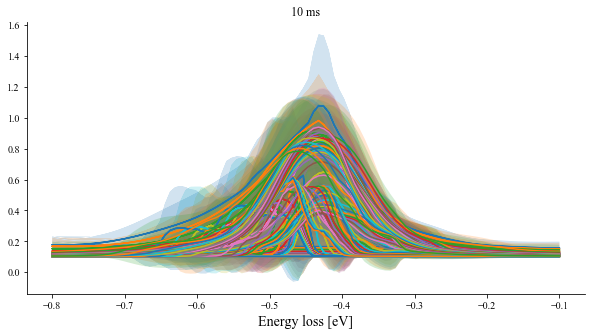

In [378]:
from matplotlib import cm
cm_subsection = np.linspace(0,1,10) 
colors = [ cm.viridis(x) for x in cm_subsection ]

groups= predict_full.groupby(['time', 'energy'])
groups_time = predict_full.groupby(['time'])
#groups_time = groups.groupby('time')
fig, ax = plt.subplots()
fig.set_size_inches((10,5))
#ax.set_color_cycle(colors)
i=0

for name, group in groups:
    ax.plot(group.x, group.pred_mean, label=str(label))
    ax.fill_between(group.x, group.pred_mean + group.pred_std/2, group.pred_mean - group.pred_std/2, alpha=.2)
    i+=1
ax.set_title('10 ms')
ax.set_xlabel('Energy loss [eV]', fontsize=14)
fig.show()

(0, 300)

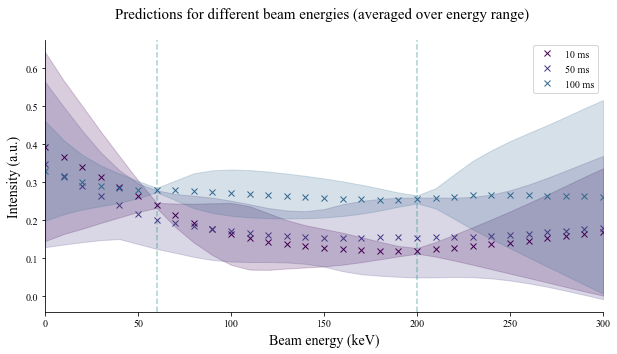

In [379]:
from matplotlib import cm
cm_subsection = np.linspace(0,1,7) 
colors = [ cm.viridis(x) for x in cm_subsection ]

fig, ax = plt.subplots()
fig.set_size_inches((10,5))
ax.axvline(60, linestyle='--', color=colors[3], alpha=.4)
ax.axvline(200, linestyle='--', color=colors[3], alpha=.4)

i=0
for name, group in groups_time:
    mean_energy = group.groupby('energy').mean()
    ax.plot(100*predict_full['energy'].unique(), mean_energy.pred_mean, 'x', color=colors[i], label=str(round(name*100))+' ms')
    ax.fill_between(100*predict_full['energy'].unique(), mean_energy.pred_mean + mean_energy.pred_std, \
                    mean_energy.pred_mean - mean_energy.pred_std, color=colors[i], alpha=.2 )
    i+=1
    
ax.legend()
ax.set_title('Predictions for different beam energies (averaged over energy range) \n', fontsize=15)
ax.set_xlabel('Beam energy (keV)', fontsize=14)
ax.set_ylabel('Intensity (a.u.)', fontsize=14)
ax.set_xlim([0,300])
 

ValueError: x and y must have same first dimension, but have shapes (31,) and (62,)

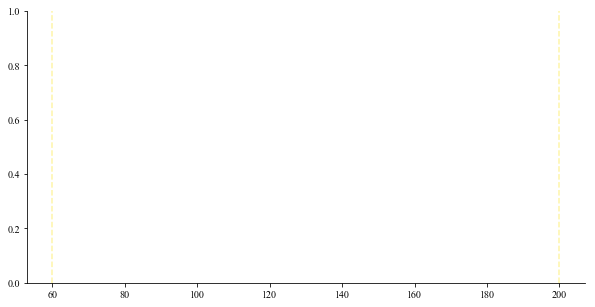

In [244]:
plt.figure(figsize=(10,5))
plt.axvline(60, linestyle='--', color=colors[10], alpha=.4)
plt.axvline(200, linestyle='--', color=colors[10], alpha=.4)


plt.plot(100*predict_full['energy'].unique(), energy_means['pred_mean'], 'x', color=colors[5], label='Mean')
plt.fill_between(100*predict_full['energy'].unique(), energy_means['pred_mean'] + energy_means['pred_std'], \
                 energy_means['pred_mean'] - energy_means['pred_std'], alpha=.2, color = colors[5], label='$\pm \sigma$')
plt.title('Predictions for different beam energies (averaged over energy range) \n', fontsize=15)
plt.xlabel('Beam energy (keV)', fontsize=14)
plt.ylabel('Intensity (a.u.)', fontsize=14)
plt.legend()
plt.xlim([0,300])
energy_means

In [195]:
totalfile = pd.concat(totalfile, energy_means)

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

Below, the distribution of $\chi^2$ is plotted for training over the $N_{rep}$ MC replicas.

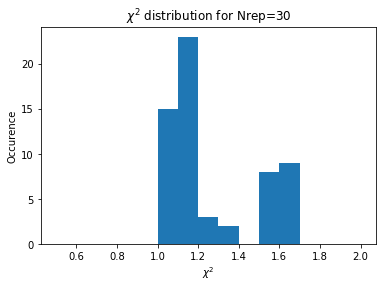

In [162]:
%run Evaluate_pseudodata.ipynb
%run Functions.ipynb
Nrep=30
plt.hist(chi2_array, bins=15, range=[0.5, 2])
plt.title('$\chi^2$ distribution for Nrep=30')
plt.xlabel('$\chi^2$')
plt.ylabel('Occurence')
plt.savefig('Data/Results/%(date)s/aaa chidistribution_%(epoch)s_Nrep=%(i)s' % {"date": d_string, "epoch": training_epochs, "i": Nrep })

plt.show()


## Residuals

In [147]:
N_train = len(train_x[:,0])

best_pred = pseudo_pred[N_train*12 :N_train*13 ]
best_y = pseudo_y[N_train*12 :N_train*13]
train_sigma = train_sigma.reshape(N_train,)

best_res = residuals(best_pred, best_y, train_sigma)

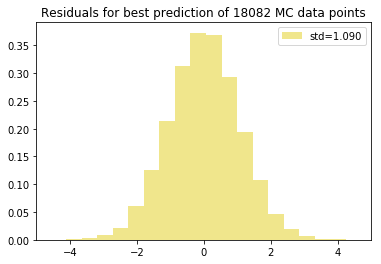

In [148]:
n, bins = np.histogram(best_res, bins=10)

mids = 0.5*(bins[1:] + bins[:-1])
probs = n / np.sum(n)

mean = np.sum(probs * mids)  
sd = np.sqrt(np.sum(probs * (mids - mean)**2))

label1 = 'std=%(std).5s' % {"std":sd}

fig = plt.hist(best_res, bins=20, density=True, color='khaki', label=label1)
plt.title('Residuals for best prediction of %(N_train)s MC data points' % {"N_train": N_train})
plt.legend([label1])

plt.xlim([-5,5])
plt.show()

## Extrapolation in energy loss

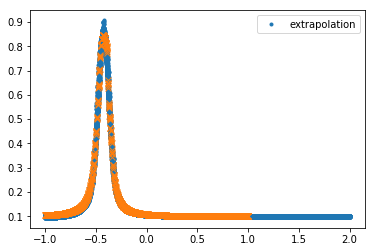

In [224]:
x_extrapol = extrapolation['dE']
prediction = extrapolation['D']
plt.plot(x_extrapol, prediction, '.', label='extrapolation')
plt.plot(train_x[index10060,0].T, predictions_values[index10060], 'x')

plt.legend()


## Interpolation in Beam Energy

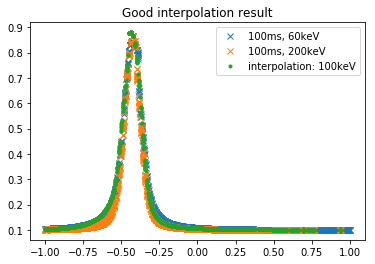

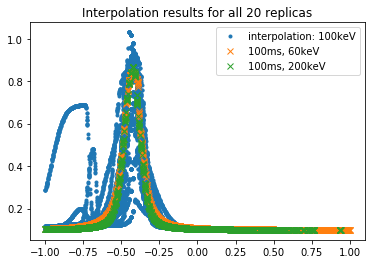

In [230]:
%run Evaluate_pseudodata.ipynb

x_interpol = interpolation['dE']

k=4
prediction_interpol = interpolation['D']
plt.plot(train_x[index10060,0].T, predictions_values[index10060], 'x', label='100ms, 60keV')
plt.plot(train_x[index100200,0].T, predictions_values[index100200], 'x', label='100ms, 200keV')
plt.plot(x_interpol[k * N_interpol : (k+1)*N_interpol], prediction_interpol[k*N_interpol :(k+1)*N_interpol], '.', label='interpolation: 100keV')
plt.title('Good interpolation result')
plt.legend()
plt.show()

plt.plot(x_interpol, prediction_interpol, '.', label='interpolation: 100keV')
plt.plot(train_x[index10060,0].T, predictions_values[index10060], 'x', label='100ms, 60keV')
plt.plot(train_x[index100200,0].T, predictions_values[index100200], 'x', label='100ms, 200keV')
plt.title('Interpolation results for all 20 replicas')
plt.legend()
plt.show()


## Write everything to report file

In [157]:
import sys
import base64

energy = 200
time = 10
nbins = 60
training_epochs = 100000

reportname = r'Reports/%(date)s_%(energy)skeV_%(time)sms_e%(epoch)s_Nrep=%(i)s.html' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
sys.stdout = open(reportname,'w')


from prettytable import PrettyTable
list1 = ['Energy:','Exposure time:','Nbins:', 'Replicas:', 'Training epochs:']
list2 = [energy, time, nbins, Nrep, training_epochs]

for x in range(0,5):
    print('%(s1)s %(s2)s <br />' % {"s1": list1[x], "s2": list2[x]}) 



In [ ]:
plot1 = r'Data/Results/%(date)s/aaa chidistribution_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot2 = r'Data/Results/%(date)s/aaa means-vs-means_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot3 = r'Data/Results/%(date)s/aaa std-vs-std_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot4 = r'Data/Results/%(date)s/aaa Residuals_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }

data_uri1 = base64.b64encode(open(plot1, 'rb').read()).decode('utf-8')
data_uri2 = base64.b64encode(open(plot2, 'rb').read()).decode('utf-8')
data_uri3 = base64.b64encode(open(plot3, 'rb').read()).decode('utf-8')
data_uri4 = base64.b64encode(open(plot4, 'rb').read()).decode('utf-8')
img_tag1 = '<img src="data:image/png;base64,{0}">'.format(data_uri1)
img_tag2 = '<img src="data:image/png;base64,{0}">'.format(data_uri2)
img_tag3 = '<img src="data:image/png;base64,{0}">'.format(data_uri3)
img_tag4 = '<img src="data:image/png;base64,{0}">'.format(data_uri4)

print(img_tag1)
print(img_tag2)
print(img_tag3)
print(img_tag4)